# Orderly Data Platform - Business Analytics

This notebook provides comprehensive business insights from the Orderly procurement data warehouse. It includes key analytics across procurement spend, data quality, price variance, regional performance, seasonal trends, vendor relationships, and executive KPIs.

## Data Model Overview

Our gold layer consists of:
- **Dimension Tables**: `dim_date`, `dim_cost_centre`, `dim_vendor`, `dim_product`
- **Fact Tables**: `fct_order_line`, `fct_data_quality`, `fct_price_variance`

## 1. Setup and Configuration

Import required libraries and configure plotting settings for data visualization.

In [76]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime

# Configure plotting settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Libraries imported and plotting configured successfully!")

✅ Libraries imported and plotting configured successfully!


## 2. Database Connection and Schema Validation

Connect to the DuckDB warehouse database and validate that all required gold layer tables and columns exist.

In [77]:
# Database connection
DB_PATH = "../warehouse/orderly.duckdb"

# Connect to DuckDB
conn = duckdb.connect(DB_PATH, read_only=True)

print(f"✅ Connected to DuckDB: {DB_PATH}")
print(f"📊 Connection established at: {datetime.now()}")

✅ Connected to DuckDB: ../warehouse/orderly.duckdb
📊 Connection established at: 2025-08-11 14:59:21.207680


In [78]:
# Validate schema and tables exist
def validate_schema():
    """Validate that all required tables exist in the gold schema"""
    
    required_tables = [
        'dev_gold.dim_date',
        'dev_gold.dim_cost_centre', 
        'dev_gold.dim_vendor',
        'dev_gold.dim_product',
        'dev_gold.fct_order_line',
        'dev_gold.fct_data_quality',
        'dev_gold.fct_price_variance'
    ]
    
    validation_results = []
    
    for table in required_tables:
        try:
            result = conn.execute(f"SELECT COUNT(*) as row_count FROM {table}").fetchone()
            row_count = result[0] if result else 0
            validation_results.append({
                'table': table,
                'status': '✅ Available',
                'row_count': row_count
            })
        except Exception as e:
            validation_results.append({
                'table': table,
                'status': f'❌ Error: {str(e)[:50]}...',
                'row_count': 0
            })
    
    return pd.DataFrame(validation_results)

# Run validation
schema_validation = validate_schema()
print("📋 Schema Validation Results:")
print(schema_validation.to_string(index=False))

# Check if all tables are available
available_tables = schema_validation[schema_validation['status'].str.contains('✅')]
print(f"\n📊 Total available tables: {len(available_tables)}/7")
print(f"📈 Total rows across all tables: {schema_validation['row_count'].sum():,}")

📋 Schema Validation Results:
                      table      status  row_count
          dev_gold.dim_date ✅ Available         92
   dev_gold.dim_cost_centre ✅ Available         12
        dev_gold.dim_vendor ✅ Available          6
       dev_gold.dim_product ✅ Available         40
    dev_gold.fct_order_line ✅ Available        267
  dev_gold.fct_data_quality ✅ Available        157
dev_gold.fct_price_variance ✅ Available          1

📊 Total available tables: 7/7
📈 Total rows across all tables: 575


## 3. 💰 Procurement Spend Analysis

_Question: What are our top spending categories by cost centre and vendor over the last quarter?_

In [79]:
# Load and execute procurement spend analysis query
with open('../notebooks/sql/1_procurement_spend_analysis.sql', 'r') as f:
    procurement_query = f.read()

print("🔍 Executing Procurement Spend Analysis...")
procurement_df = conn.execute(procurement_query).df()

print(f"📊 Results: {len(procurement_df)} records found")
print("\n🔝 Top 10 Spending Categories:")
display(procurement_df.head(10))

🔍 Executing Procurement Spend Analysis...
📊 Results: 20 records found

🔝 Top 10 Spending Categories:


,cost_centre_name,vendor_name,product_category,total_spend_aud,total_quantity,order_line_count,avg_cost_per_unit
0,United States - Operations,TechFlow Corporation,Keyboards,11924.07,28.00,3,425.86
1,Australia - Marketing,DataVault Corporation,Storage,11761.32,43.00,5,273.52
2,United States - Operations,ConnectPro Corporation,Cables,11694.87,33.00,5,354.39
3,United States - Marketing,ConnectPro Corporation,Cables,11457.48,25.00,6,458.30
4,United States - Operations,DataVault Corporation,Storage,10748.96,22.00,4,488.59
5,United States - IT,TechFlow Corporation,Keyboards,10639.34,25.00,7,425.57
6,United States - IT,OfficeLink Corporation,Headsets,9908.58,34.00,4,291.43
7,United States - HR,TechFlow Corporation,Keyboards,9836.23,29.00,7,339.18
8,Australia - IT,TechFlow Corporation,Keyboards,9482.39,31.00,8,305.88
9,Australia - Finance,TechFlow Corporation,Keyboards,7706.62,26.00,9,296.41


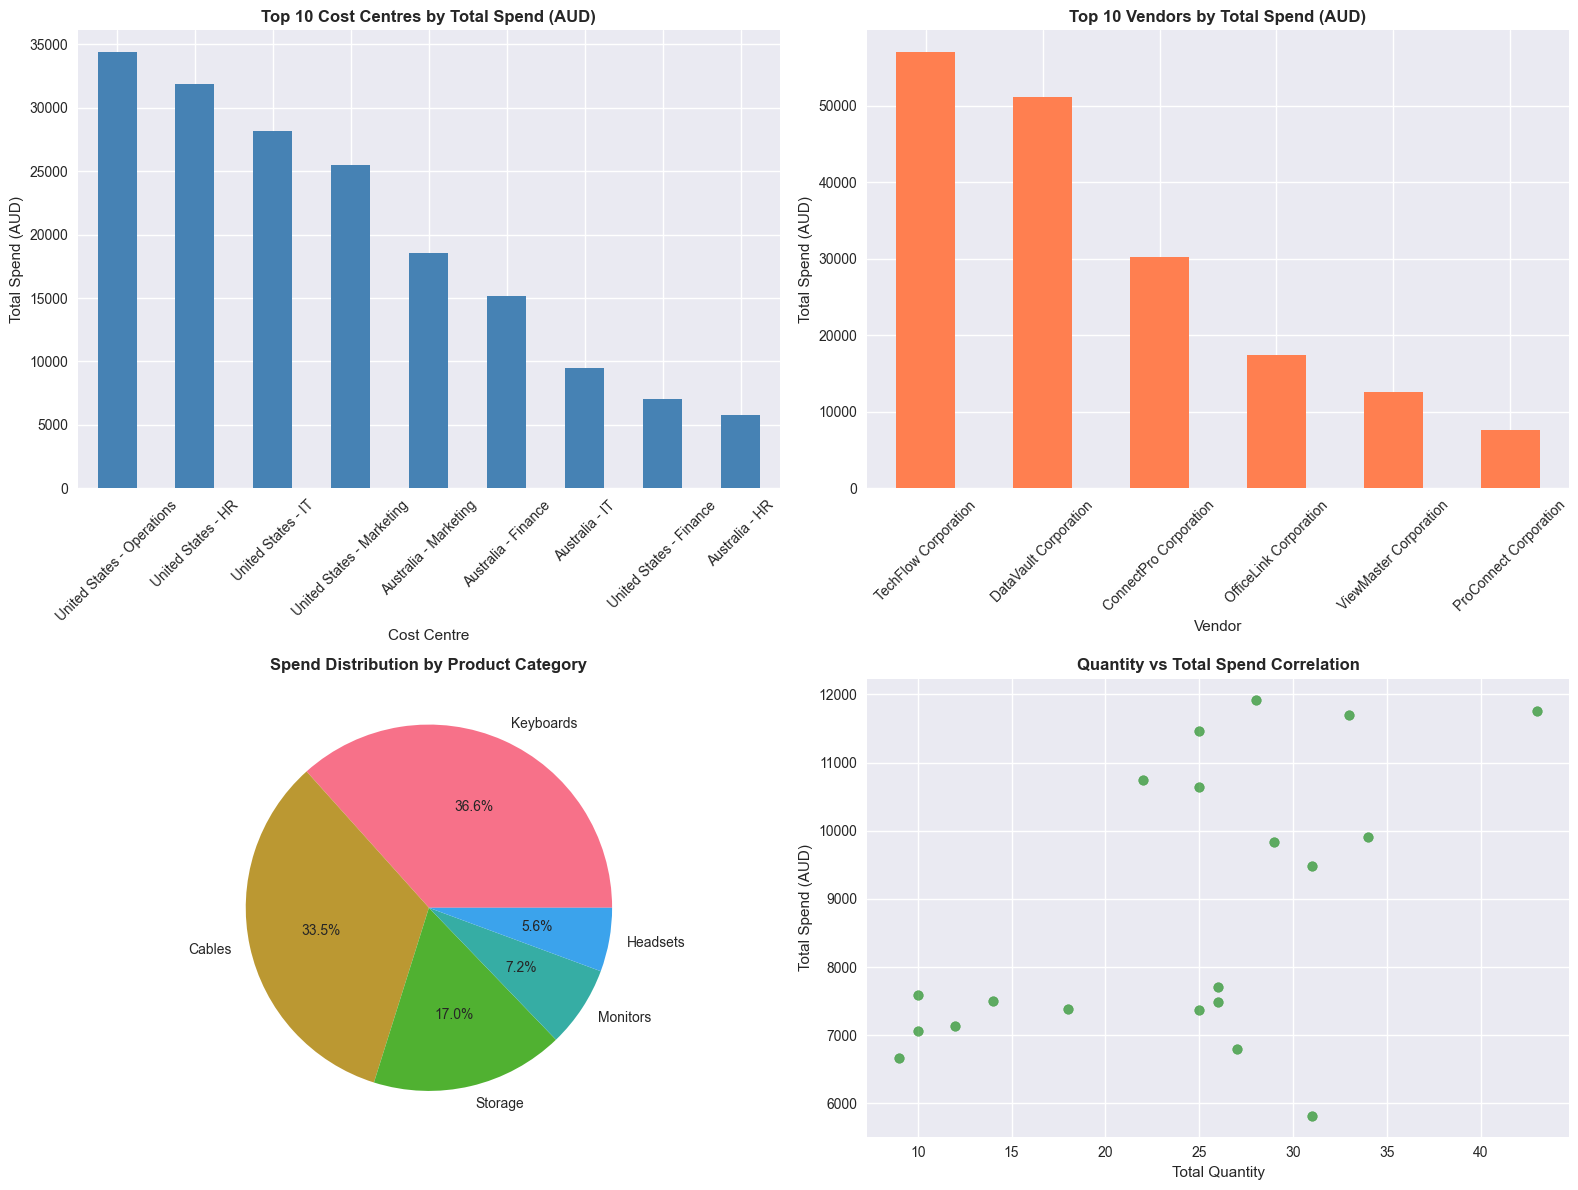


📈 Procurement Spend Summary:
💰 Total Spend (AUD): $175,966.08
📦 Total Quantity: 478
📋 Total Order Lines: 92
💵 Average Cost per Unit: $421.37


In [80]:
# Visualization: Top spending by cost centre
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 Cost Centres by Spend
top_cost_centres = procurement_df.groupby('cost_centre_name')['total_spend_aud'].sum().sort_values(ascending=False).head(10)
top_cost_centres.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Top 10 Cost Centres by Total Spend (AUD)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cost Centre')
ax1.set_ylabel('Total Spend (AUD)')
ax1.tick_params(axis='x', rotation=45)

# 2. Top 10 Vendors by Spend
top_vendors = procurement_df.groupby('vendor_name')['total_spend_aud'].sum().sort_values(ascending=False).head(10)
top_vendors.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Top 10 Vendors by Total Spend (AUD)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Vendor')
ax2.set_ylabel('Total Spend (AUD)')
ax2.tick_params(axis='x', rotation=45)

# 3. Spend by Product Category
category_spend = procurement_df.groupby('product_category')['total_spend_aud'].sum().sort_values(ascending=False)
category_spend.plot(kind='pie', ax=ax3, autopct='%1.1f%%')
ax3.set_title('Spend Distribution by Product Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('')

# 4. Quantity vs Spend Correlation
ax4.scatter(procurement_df['total_quantity'], procurement_df['total_spend_aud'], alpha=0.6, color='green')
ax4.set_title('Quantity vs Total Spend Correlation', fontsize=12, fontweight='bold')
ax4.set_xlabel('Total Quantity')
ax4.set_ylabel('Total Spend (AUD)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📈 Procurement Spend Summary:")
print(f"💰 Total Spend (AUD): ${procurement_df['total_spend_aud'].sum():,.2f}")
print(f"📦 Total Quantity: {procurement_df['total_quantity'].sum():,.0f}")
print(f"📋 Total Order Lines: {procurement_df['order_line_count'].sum():,.0f}")
print(f"💵 Average Cost per Unit: ${procurement_df['avg_cost_per_unit'].mean():.2f}")

## 4. 📊 Data Quality Monitoring

_Question: What are the most common data quality issues and which cost centres have the highest exception rates?_

In [81]:
# Load and execute data quality monitoring query
with open('../notebooks/sql/2_data_quality_monitoring.sql', 'r') as f:
    quality_query = f.read()

print("🔍 Executing Data Quality Monitoring Analysis...")
quality_df = conn.execute(quality_query).df()

print(f"📊 Results: {len(quality_df)} exception records found")
print("\n⚠️ Top 10 Exception Areas:")
display(quality_df.head(10))

🔍 Executing Data Quality Monitoring Analysis...
📊 Results: 31 exception records found

⚠️ Top 10 Exception Areas:


,cost_centre_name,exception_type,exception_count,avg_fuzz_score,missing_in_seed_count,name_mismatch_count,vendor_mismatch_count,exception_rate_percent
0,Australia - Marketing,NAME_MISMATCH,14,0.41,0.00,14.00,1.00,42.42
1,United States - Operations,NAME_MISMATCH,11,0.43,0.00,11.00,0.00,40.74
2,Australia - IT,NAME_MISMATCH,11,0.38,0.00,11.00,0.00,40.74
3,Australia - Operations,NAME_MISMATCH,10,0.42,0.00,10.00,0.00,55.56
4,United States - Marketing,NAME_MISMATCH,9,0.40,0.00,9.00,0.00,42.86
5,Australia - Finance,NAME_MISMATCH,9,0.40,0.00,9.00,0.00,25.71
6,Australia - IT,NAME_MISMATCH,8,0.41,0.00,8.00,0.00,29.63
7,United States - Marketing,NAME_MISMATCH,8,0.39,0.00,8.00,1.00,38.10
8,Australia - Marketing,NAME_MISMATCH,7,0.45,0.00,7.00,0.00,21.21
9,United States - HR,NAME_MISMATCH,7,0.35,0.00,7.00,1.00,21.21


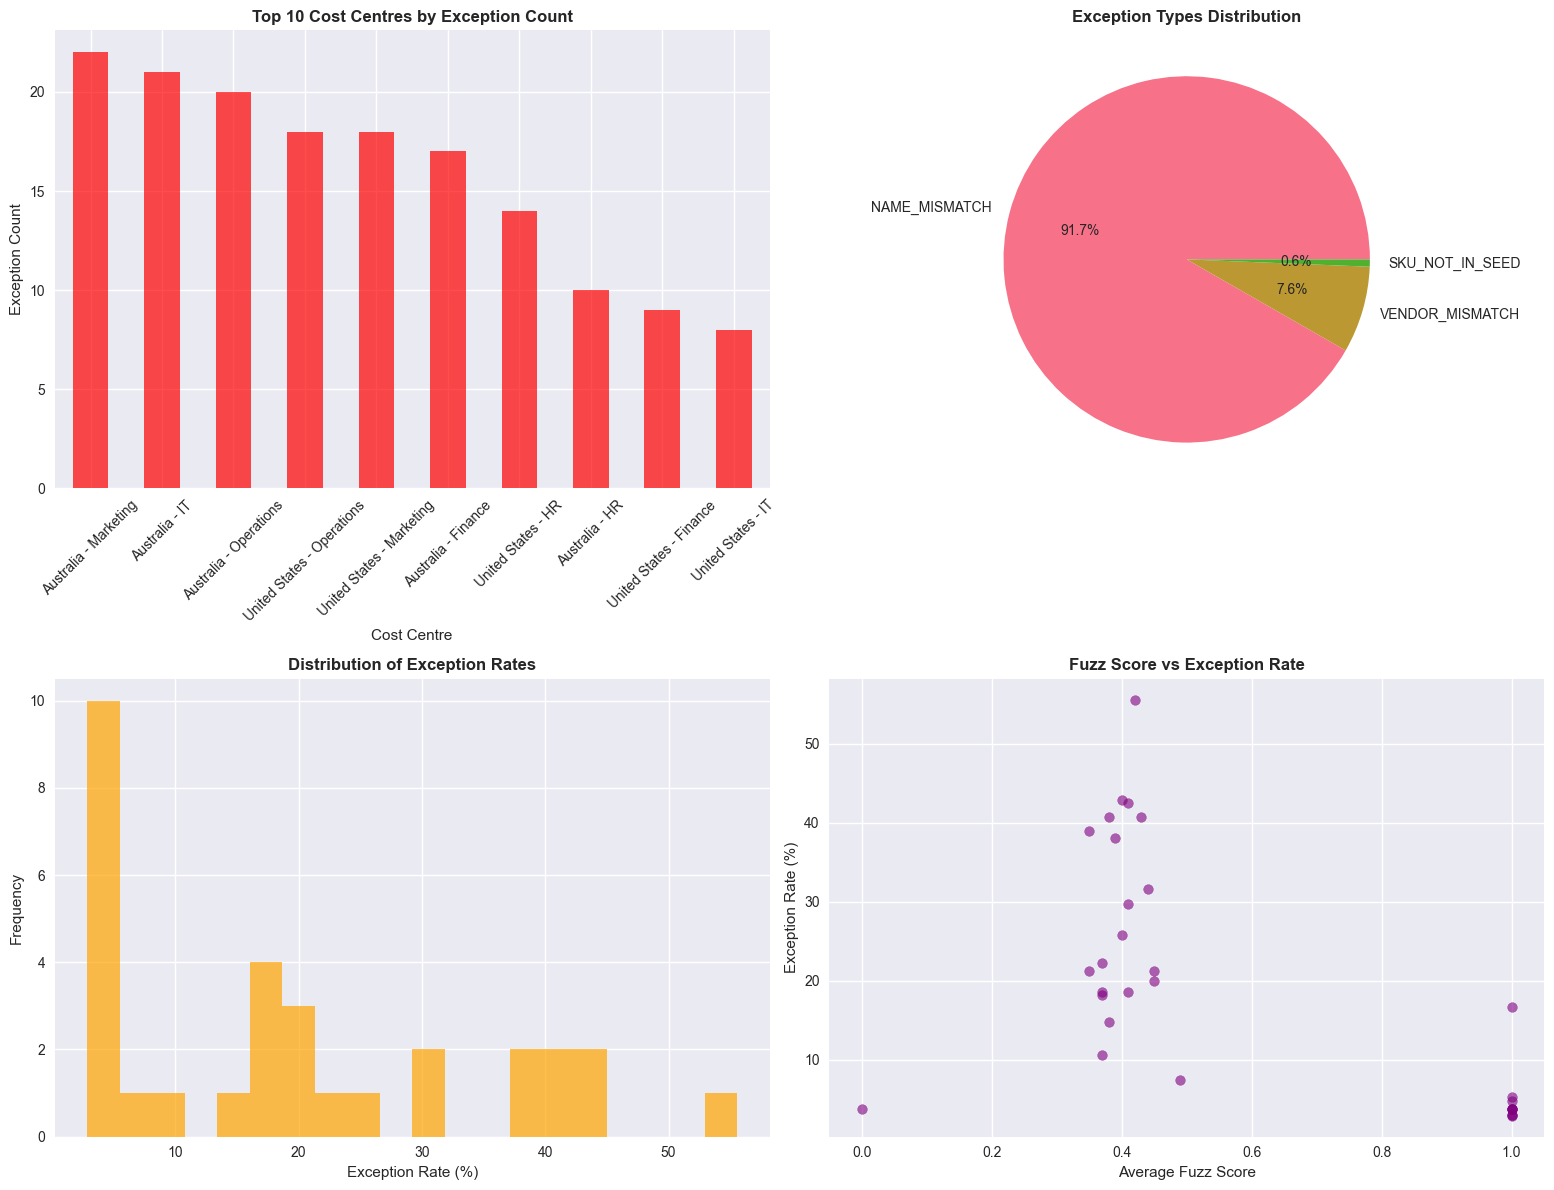


📊 Data Quality Summary:
⚠️ Total Exceptions: 157
📊 Average Exception Rate: 19.77%
🎯 Average Fuzz Score: 0.58
🔍 Missing in Seed Issues: 1
📝 Name Mismatch Issues: 144
🏢 Vendor Mismatch Issues: 18


In [82]:
# Visualization: Data Quality Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Exception Count by Cost Centre
cc_exceptions = quality_df.groupby('cost_centre_name')['exception_count'].sum().sort_values(ascending=False).head(10)
cc_exceptions.plot(kind='bar', ax=ax1, color='red', alpha=0.7)
ax1.set_title('Top 10 Cost Centres by Exception Count', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cost Centre')
ax1.set_ylabel('Exception Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Exception Types Distribution
exception_types = quality_df.groupby('exception_type')['exception_count'].sum().sort_values(ascending=False)
exception_types.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Exception Types Distribution', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

# 3. Exception Rate Distribution
quality_df['exception_rate_percent'].hist(bins=20, ax=ax3, color='orange', alpha=0.7)
ax3.set_title('Distribution of Exception Rates', fontsize=12, fontweight='bold')
ax3.set_xlabel('Exception Rate (%)')
ax3.set_ylabel('Frequency')

# 4. Fuzz Score vs Exception Rate
ax4.scatter(quality_df['avg_fuzz_score'], quality_df['exception_rate_percent'], alpha=0.6, color='purple')
ax4.set_title('Fuzz Score vs Exception Rate', fontsize=12, fontweight='bold')
ax4.set_xlabel('Average Fuzz Score')
ax4.set_ylabel('Exception Rate (%)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Data Quality Summary:")
print(f"⚠️ Total Exceptions: {quality_df['exception_count'].sum():,.0f}")
print(f"📊 Average Exception Rate: {quality_df['exception_rate_percent'].mean():.2f}%")
print(f"🎯 Average Fuzz Score: {quality_df['avg_fuzz_score'].mean():.2f}")
print(f"🔍 Missing in Seed Issues: {quality_df['missing_in_seed_count'].sum():,.0f}")
print(f"📝 Name Mismatch Issues: {quality_df['name_mismatch_count'].sum():,.0f}")
print(f"🏢 Vendor Mismatch Issues: {quality_df['vendor_mismatch_count'].sum():,.0f}")

## 5. 🔍 Price Variance and Anomaly Detection

_Question: Which products show the highest price volatility and potential savings opportunities?_

In [83]:
# Load and execute price variance analysis query
with open('../notebooks/sql/3_price_variance_analysis.sql', 'r') as f:
    price_query = f.read()

print("🔍 Executing Price Variance Analysis...")
price_df = conn.execute(price_query).df()

print(f"📊 Results: {len(price_df)} products with significant price variance")
print("\n💰 Top 10 Savings Opportunities:")
display(price_df.head(10))

🔍 Executing Price Variance Analysis...
📊 Results: 1 products with significant price variance

💰 Top 10 Savings Opportunities:


,sku_id,canonical_name,product_category,vendor_name,cost_centre_name,month_name,year,avg_unit_price,min_unit_price,max_unit_price,price_stddev,order_count,total_quantity,price_volatility_percent,potential_savings_aud
0,SKU101,tf wireless keyboard,Keyboards,TechFlow Corporation,Australia - HR,July,2025,170.36,95.21,245.52,106.28,2,6.00,88.23,450.91


## 6. 🌍 Multi-Region Cost Centre Performance

_Question: How do procurement patterns differ between AU and US cost centres?_

In [84]:
# Load and execute multi-region performance query
with open('../notebooks/sql/4_multi_region_performance.sql', 'r') as f:
    region_query = f.read()

print("🔍 Executing Multi-Region Performance Analysis...")
region_df = conn.execute(region_query).df()

print(f"📊 Results: {len(region_df)} regional performance records")
print("\n🌍 Regional Performance Overview:")
display(region_df.head(15))

🔍 Executing Multi-Region Performance Analysis...
📊 Results: 10 regional performance records

🌍 Regional Performance Overview:


,country_code,region,vendor_category,region_total_spend_aud,avg_line_value_aud,total_orders,total_line_items,avg_order_value,avg_lines_per_order,avg_vendors_per_cc,avg_products_per_cc
0,AU,APAC,Data & Storage,42985.65,1557.36,28.00,28.00,1535.20,1.00,1.00,4.00
1,AU,APAC,Connectivity,37167.62,1083.36,35.00,35.00,1061.93,1.00,2.00,5.20
2,AU,APAC,Technology,26460.20,731.14,33.00,33.00,801.82,1.00,1.00,4.20
3,AU,APAC,Display Equipment,25031.56,702.63,33.00,33.00,758.53,1.00,1.00,4.00
4,AU,APAC,Office Supplies,13331.47,1235.57,11.00,11.00,1211.95,1.00,1.00,2.50
5,US,Americas,Connectivity,71134.04,2074.54,37.00,37.00,1922.54,1.00,2.00,5.60
6,US,Americas,Data & Storage,46550.05,1867.60,24.00,24.00,1939.59,1.00,1.00,3.40
7,US,Americas,Technology,45054.31,1799.79,26.00,26.00,1732.86,1.00,1.00,3.40
8,US,Americas,Office Supplies,38036.11,1783.98,22.00,22.00,1728.91,1.00,1.00,2.80
9,US,Americas,Display Equipment,21359.07,1359.11,18.00,18.00,1186.61,1.00,1.00,2.80


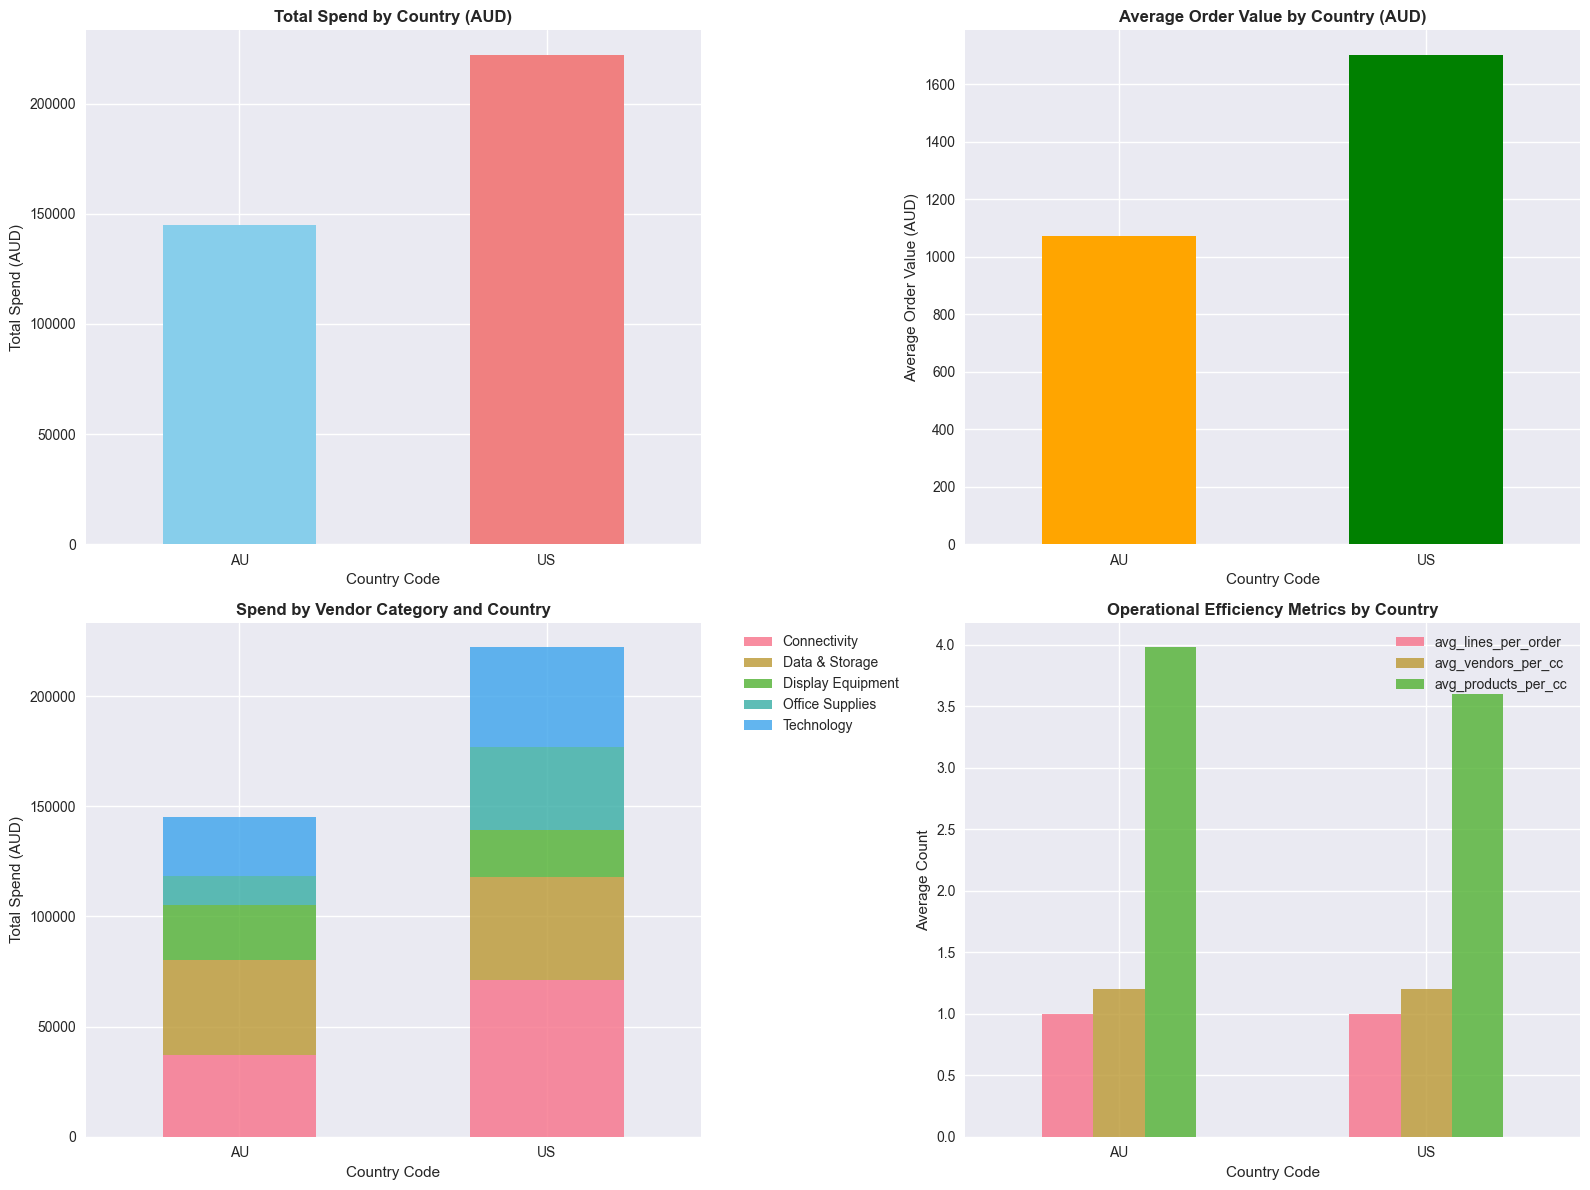


🌍 Regional Performance Summary:


,region_total_spend_aud,total_orders,total_line_items,avg_order_value,avg_lines_per_order
country_code,,,,,
AU,144976.50,140.00,140.00,1073.89,1.00
US,222133.58,127.00,127.00,1702.10,1.00


In [85]:
# Visualization: Multi-Region Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Spend by Country and Region
country_spend = region_df.groupby('country_code')['region_total_spend_aud'].sum()
country_spend.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Total Spend by Country (AUD)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Country Code')
ax1.set_ylabel('Total Spend (AUD)')
ax1.tick_params(axis='x', rotation=0)

# 2. Average Order Value by Country
country_order_value = region_df.groupby('country_code')['avg_order_value'].mean()
country_order_value.plot(kind='bar', ax=ax2, color=['orange', 'green'])
ax2.set_title('Average Order Value by Country (AUD)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Country Code')
ax2.set_ylabel('Average Order Value (AUD)')
ax2.tick_params(axis='x', rotation=0)

# 3. Vendor Category Distribution by Country
vendor_category_pivot = region_df.pivot_table(
    values='region_total_spend_aud', 
    index='country_code', 
    columns='vendor_category', 
    aggfunc='sum', 
    fill_value=0
)
vendor_category_pivot.plot(kind='bar', stacked=True, ax=ax3, alpha=0.8)
ax3.set_title('Spend by Vendor Category and Country', fontsize=12, fontweight='bold')
ax3.set_xlabel('Country Code')
ax3.set_ylabel('Total Spend (AUD)')
ax3.tick_params(axis='x', rotation=0)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Efficiency Metrics Comparison
efficiency_metrics = region_df.groupby('country_code')[['avg_lines_per_order', 'avg_vendors_per_cc', 'avg_products_per_cc']].mean()
efficiency_metrics.plot(kind='bar', ax=ax4, alpha=0.8)
ax4.set_title('Operational Efficiency Metrics by Country', fontsize=12, fontweight='bold')
ax4.set_xlabel('Country Code')
ax4.set_ylabel('Average Count')
ax4.tick_params(axis='x', rotation=0)
ax4.legend()

plt.tight_layout()
plt.show()

# Summary statistics by country
print("\n🌍 Regional Performance Summary:")
country_summary = region_df.groupby('country_code').agg({
    'region_total_spend_aud': 'sum',
    'total_orders': 'sum',
    'total_line_items': 'sum',
    'avg_order_value': 'mean',
    'avg_lines_per_order': 'mean'
}).round(2)

display(country_summary)

## 7. ⏰ Seasonal Procurement Trends

_Question: What are the seasonal spending patterns and how do they vary by product category?_

In [86]:
# Load and execute seasonal trends analysis query
with open('../notebooks/sql/5_seasonal_trends.sql', 'r') as f:
    seasonal_query = f.read()

print("🔍 Executing Seasonal Trends Analysis...")
seasonal_df = conn.execute(seasonal_query).df()

print(f"📊 Results: {len(seasonal_df)} monthly trend records")
print("\n📅 Sample Seasonal Trends:")
display(seasonal_df.head(12))

🔍 Executing Seasonal Trends Analysis...
📊 Results: 22 monthly trend records

📅 Sample Seasonal Trends:


,month,quarter,product_category,product_brand,monthly_spend_aud,monthly_quantity,monthly_orders,spend_seasonality_zscore,spend_variance_from_avg_percent
0,7,3,Adapters,Generic,8503.24,42.00,9,-0.71,-34.00
1,8,3,Adapters,Generic,17264.51,49.00,12,0.71,34.00
2,7,3,Cables,Generic,27778.89,70.00,12,0.63,18.11
3,7,3,Cables,ConnectPro,20776.56,67.00,13,-0.41,-11.66
4,8,3,Cables,Generic,30132.42,85.00,14,0.98,28.12
5,8,3,Cables,ConnectPro,15388.73,52.00,10,-1.21,-34.57
6,7,3,Headsets,Generic,27092.06,99.00,18,0.71,20.64
7,8,3,Headsets,Generic,17823.62,48.00,14,-0.71,-20.64
8,7,3,Keyboards,ConnectPro,83.51,1.00,1,-0.88,-99.55
9,7,3,Keyboards,Generic,41769.12,116.00,29,1.10,123.61


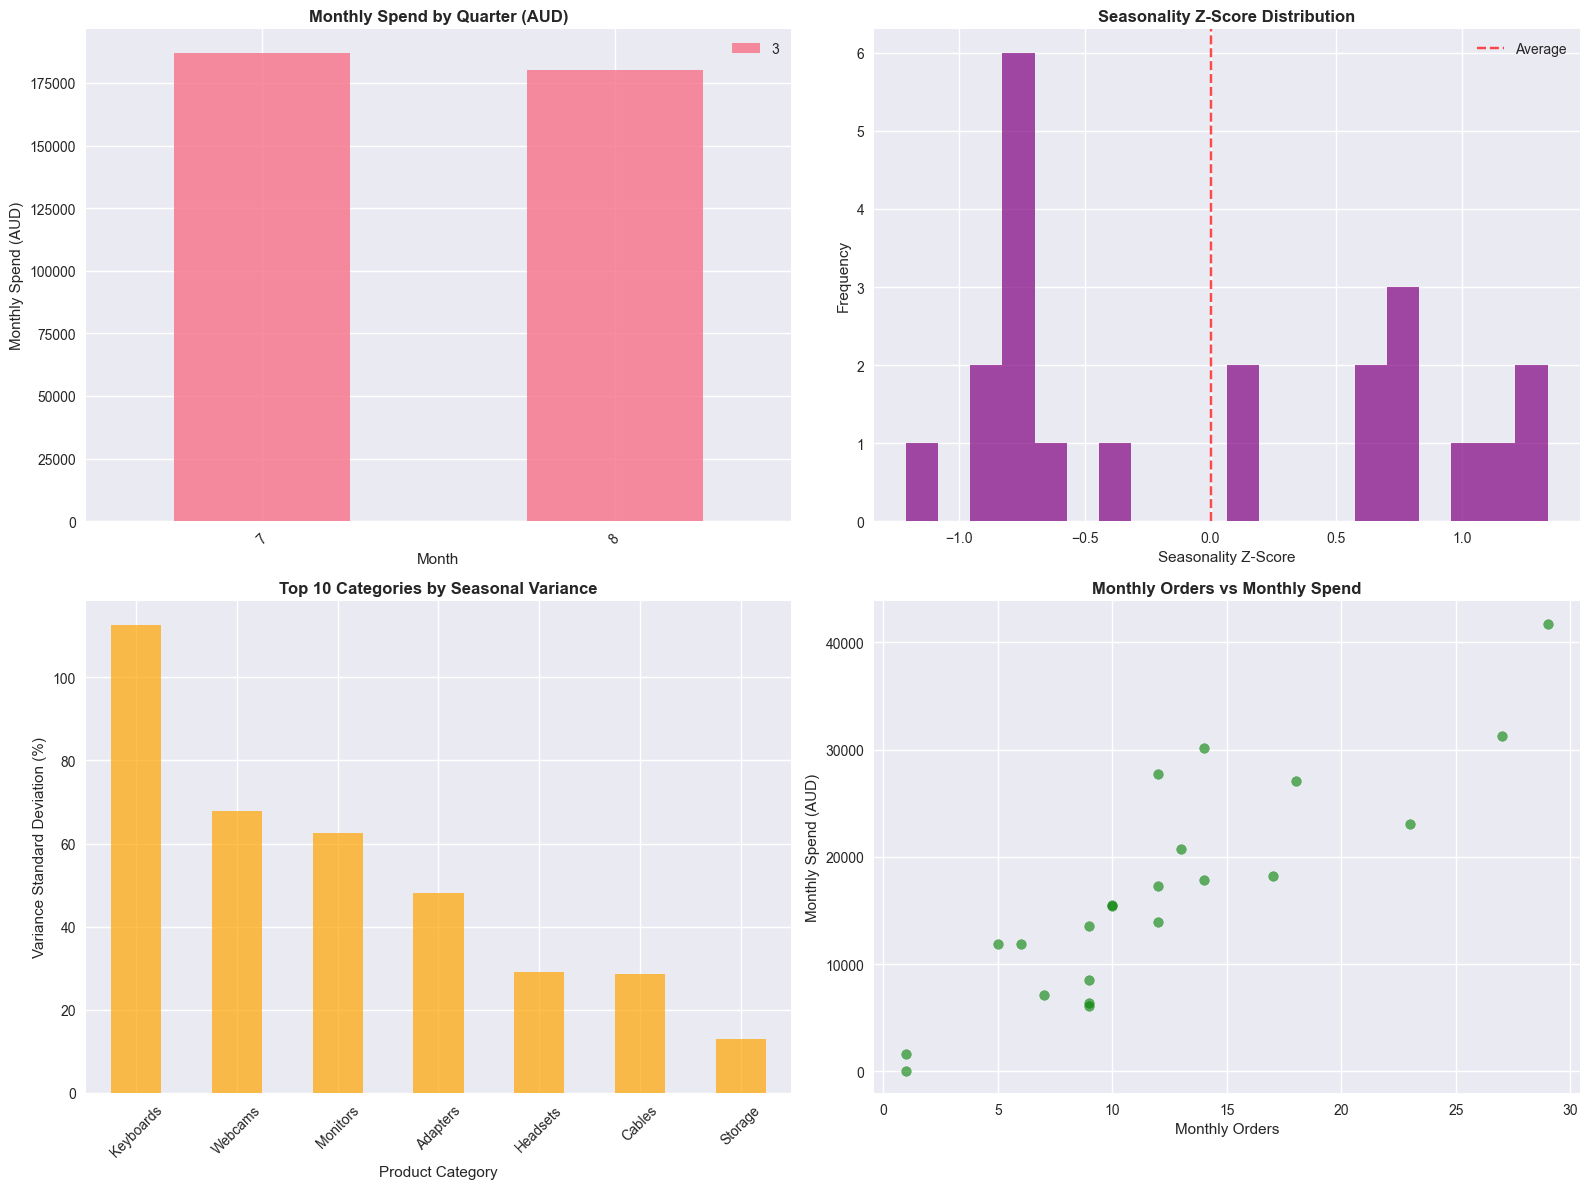


📅 Seasonal Trends Summary:
📊 Average Monthly Spend: $16,686.82
📈 Peak Monthly Spend: $41,769.12
📉 Lowest Monthly Spend: $83.51
🎯 Seasonality Score Range: -1.21 to 1.34
📦 Product Categories Analyzed: 7


In [87]:
# Visualization: Seasonal Trends Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Monthly Spend Trends by Quarter
quarterly_spend = seasonal_df.groupby(['quarter', 'month'])['monthly_spend_aud'].sum().reset_index()
quarter_pivot = quarterly_spend.pivot(index='month', columns='quarter', values='monthly_spend_aud')
quarter_pivot.plot(kind='bar', ax=ax1, alpha=0.8)
ax1.set_title('Monthly Spend by Quarter (AUD)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Spend (AUD)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# 2. Seasonality Z-Score Distribution
seasonal_df['spend_seasonality_zscore'].hist(bins=20, ax=ax2, color='purple', alpha=0.7)
ax2.set_title('Seasonality Z-Score Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Seasonality Z-Score')
ax2.set_ylabel('Frequency')
ax2.axvline(0, color='red', linestyle='--', alpha=0.7, label='Average')
ax2.legend()

# 3. Top Product Categories by Seasonal Variance
category_variance = seasonal_df.groupby('product_category')['spend_variance_from_avg_percent'].std().sort_values(ascending=False).head(10)
category_variance.plot(kind='bar', ax=ax3, color='orange', alpha=0.7)
ax3.set_title('Top 10 Categories by Seasonal Variance', fontsize=12, fontweight='bold')
ax3.set_xlabel('Product Category')
ax3.set_ylabel('Variance Standard Deviation (%)')
ax3.tick_params(axis='x', rotation=45)

# 4. Monthly Orders vs Spend Correlation
ax4.scatter(seasonal_df['monthly_orders'], seasonal_df['monthly_spend_aud'], alpha=0.6, color='green')
ax4.set_title('Monthly Orders vs Monthly Spend', fontsize=12, fontweight='bold')
ax4.set_xlabel('Monthly Orders')
ax4.set_ylabel('Monthly Spend (AUD)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📅 Seasonal Trends Summary:")
print(f"📊 Average Monthly Spend: ${seasonal_df['monthly_spend_aud'].mean():,.2f}")
print(f"📈 Peak Monthly Spend: ${seasonal_df['monthly_spend_aud'].max():,.2f}")
print(f"📉 Lowest Monthly Spend: ${seasonal_df['monthly_spend_aud'].min():,.2f}")
print(f"🎯 Seasonality Score Range: {seasonal_df['spend_seasonality_zscore'].min():.2f} to {seasonal_df['spend_seasonality_zscore'].max():.2f}")
print(f"📦 Product Categories Analyzed: {seasonal_df['product_category'].nunique()}")

## 8. 🎯 Vendor Performance and Relationship Analysis

_Question: Which vendors provide the best value and should we consolidate our vendor relationships?_

In [88]:
# Load and execute vendor performance analysis query
with open('../notebooks/sql/6_vendor_performance.sql', 'r') as f:
    vendor_query = f.read()

print("🔍 Executing Vendor Performance Analysis...")
vendor_df = conn.execute(vendor_query).df()

print(f"📊 Results: {len(vendor_df)} vendor performance records")
print("\n🏆 Top 10 Vendors by Spend:")
display(vendor_df.head(10))

🔍 Executing Vendor Performance Analysis...
📊 Results: 6 vendor performance records

🏆 Top 10 Vendors by Spend:


,vendor_name,vendor_category,vendor_tier,vendor_country,total_spend_aud,total_orders,unique_products_supplied,cost_centres_served,data_quality_issues,spend_rank,volume_rank,diversity_rank,quality_rank,spend_concentration_percent,avg_line_value_aud,avg_order_value_aud,vendor_classification
0,DataVault Corporation,Data & Storage,Preferred,SG,89535.70,52,9,10,21,1,2,3,3,24.39,1721.84,1721.84,Strategic Partner
1,TechFlow Corporation,Technology,Standard,US,71514.51,59,12,10,28,2,1,1,5,19.48,1212.11,1212.11,Key Supplier
2,ConnectPro Corporation,Connectivity,Standard,DE,63736.71,43,10,10,26,3,4,2,4,17.36,1482.25,1482.25,Key Supplier
3,OfficeLink Corporation,Office Supplies,Standard,US,51367.58,33,9,9,16,4,5,4,1,13.99,1556.59,1556.59,Standard Supplier
4,ViewMaster Corporation,Display Equipment,Standard,AU,46390.63,51,8,10,29,5,3,5,6,12.64,909.62,909.62,Standard Supplier
5,ProConnect Corporation,Connectivity,Standard,UK,44564.94,29,7,10,19,6,6,6,2,12.14,1536.72,1536.72,Standard Supplier


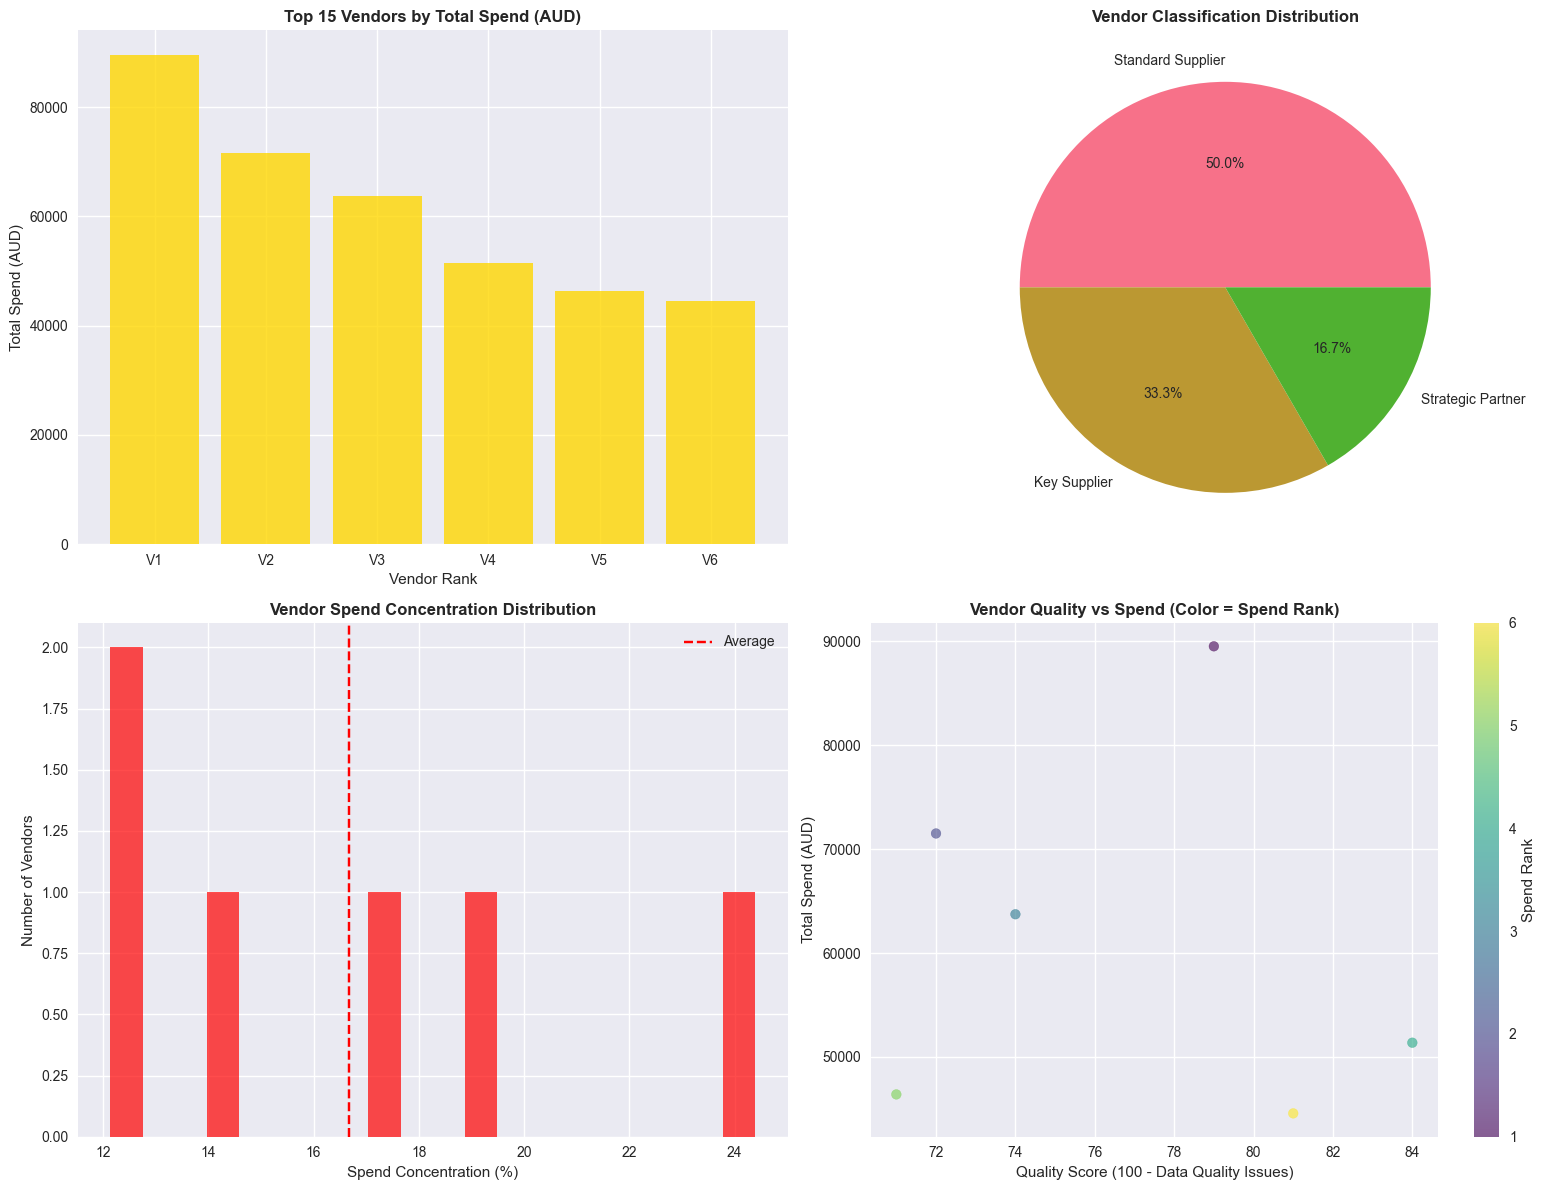


🎯 Vendor Performance Summary:


,vendor_count,total_spend_sum,avg_spend_per_vendor,total_concentration,avg_quality_issues
vendor_classification,,,,,
Key Supplier,2,135251.22,67625.61,36.84,27.00
Standard Supplier,3,142323.15,47441.05,38.77,21.33
Strategic Partner,1,89535.70,89535.70,24.39,21.00



📈 Top Vendor Insights:
🥇 Highest Spending Vendor: DataVault Corporation ($89,535.70)
⭐ Strategic Partners: 1
🔄 Consolidation Candidates: 0
📊 Total Vendor Concentration: 100.0%


In [89]:
# Visualization: Vendor Performance Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 15 Vendors by Spend
top_vendors_spend = vendor_df.head(15)
bars = ax1.bar(range(len(top_vendors_spend)), top_vendors_spend['total_spend_aud'], color='gold', alpha=0.8)
ax1.set_title('Top 15 Vendors by Total Spend (AUD)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Vendor Rank')
ax1.set_ylabel('Total Spend (AUD)')
ax1.set_xticks(range(len(top_vendors_spend)))
ax1.set_xticklabels([f"V{i+1}" for i in range(len(top_vendors_spend))])

# 2. Vendor Classification Distribution
classification_counts = vendor_df['vendor_classification'].value_counts()
classification_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Vendor Classification Distribution', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

# 3. Spend Concentration Analysis
vendor_df['spend_concentration_percent'].hist(bins=20, ax=ax3, color='red', alpha=0.7)
ax3.set_title('Vendor Spend Concentration Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Spend Concentration (%)')
ax3.set_ylabel('Number of Vendors')
ax3.axvline(vendor_df['spend_concentration_percent'].mean(), color='red', linestyle='--', label='Average')
ax3.legend()

# 4. Quality Score vs Spend Relationship
# Create a quality score based on data quality issues (inverse)
vendor_df['quality_score'] = 100 - vendor_df['data_quality_issues']
ax4.scatter(vendor_df['quality_score'], vendor_df['total_spend_aud'], 
           alpha=0.6, c=vendor_df['spend_rank'], cmap='viridis')
ax4.set_title('Vendor Quality vs Spend (Color = Spend Rank)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Quality Score (100 - Data Quality Issues)')
ax4.set_ylabel('Total Spend (AUD)')
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Spend Rank')

plt.tight_layout()
plt.show()

# Vendor Classification Summary
print("\n🎯 Vendor Performance Summary:")
classification_summary = vendor_df.groupby('vendor_classification').agg({
    'vendor_name': 'count',
    'total_spend_aud': ['sum', 'mean'],
    'spend_concentration_percent': 'sum',
    'data_quality_issues': 'mean'
}).round(2)

# Flatten column names
classification_summary.columns = ['vendor_count', 'total_spend_sum', 'avg_spend_per_vendor', 'total_concentration', 'avg_quality_issues']
display(classification_summary)

print(f"\n📈 Top Vendor Insights:")
print(f"🥇 Highest Spending Vendor: {vendor_df.iloc[0]['vendor_name']} (${vendor_df.iloc[0]['total_spend_aud']:,.2f})")
print(f"⭐ Strategic Partners: {len(vendor_df[vendor_df['vendor_classification'] == 'Strategic Partner'])}")
print(f"🔄 Consolidation Candidates: {len(vendor_df[vendor_df['vendor_classification'] == 'Consolidation Candidate'])}")
print(f"📊 Total Vendor Concentration: {vendor_df['spend_concentration_percent'].sum():.1f}%")

## 9. 📈 Executive Summary Dashboard

Generate key KPIs for executive reporting including month-over-month growth metrics and quality scores with summary visualizations.

In [90]:
# Load and execute executive dashboard query
with open('../notebooks/sql/7_executive_dashboard.sql', 'r') as f:
    executive_query = f.read()

print("🔍 Executing Executive Dashboard Analysis...")
executive_df = conn.execute(executive_query).df()

print(f"📊 Executive KPI Results:")
display(executive_df)

🔍 Executing Executive Dashboard Analysis...
📊 Executive KPI Results:


,period_name,total_spend_aud,total_orders,total_line_items,active_vendors,unique_products,avg_line_value,total_exceptions,avg_data_quality_score,mom_spend_growth_percent
0,Current Month,180085.75,129,129,6,34,1396.01,89,0.45,-3.71
1,Previous Month,187024.33,138,138,6,36,1355.25,89,0.45,NaN
2,Year to Date,367110.08,267,267,6,40,1374.94,89,0.45,NaN


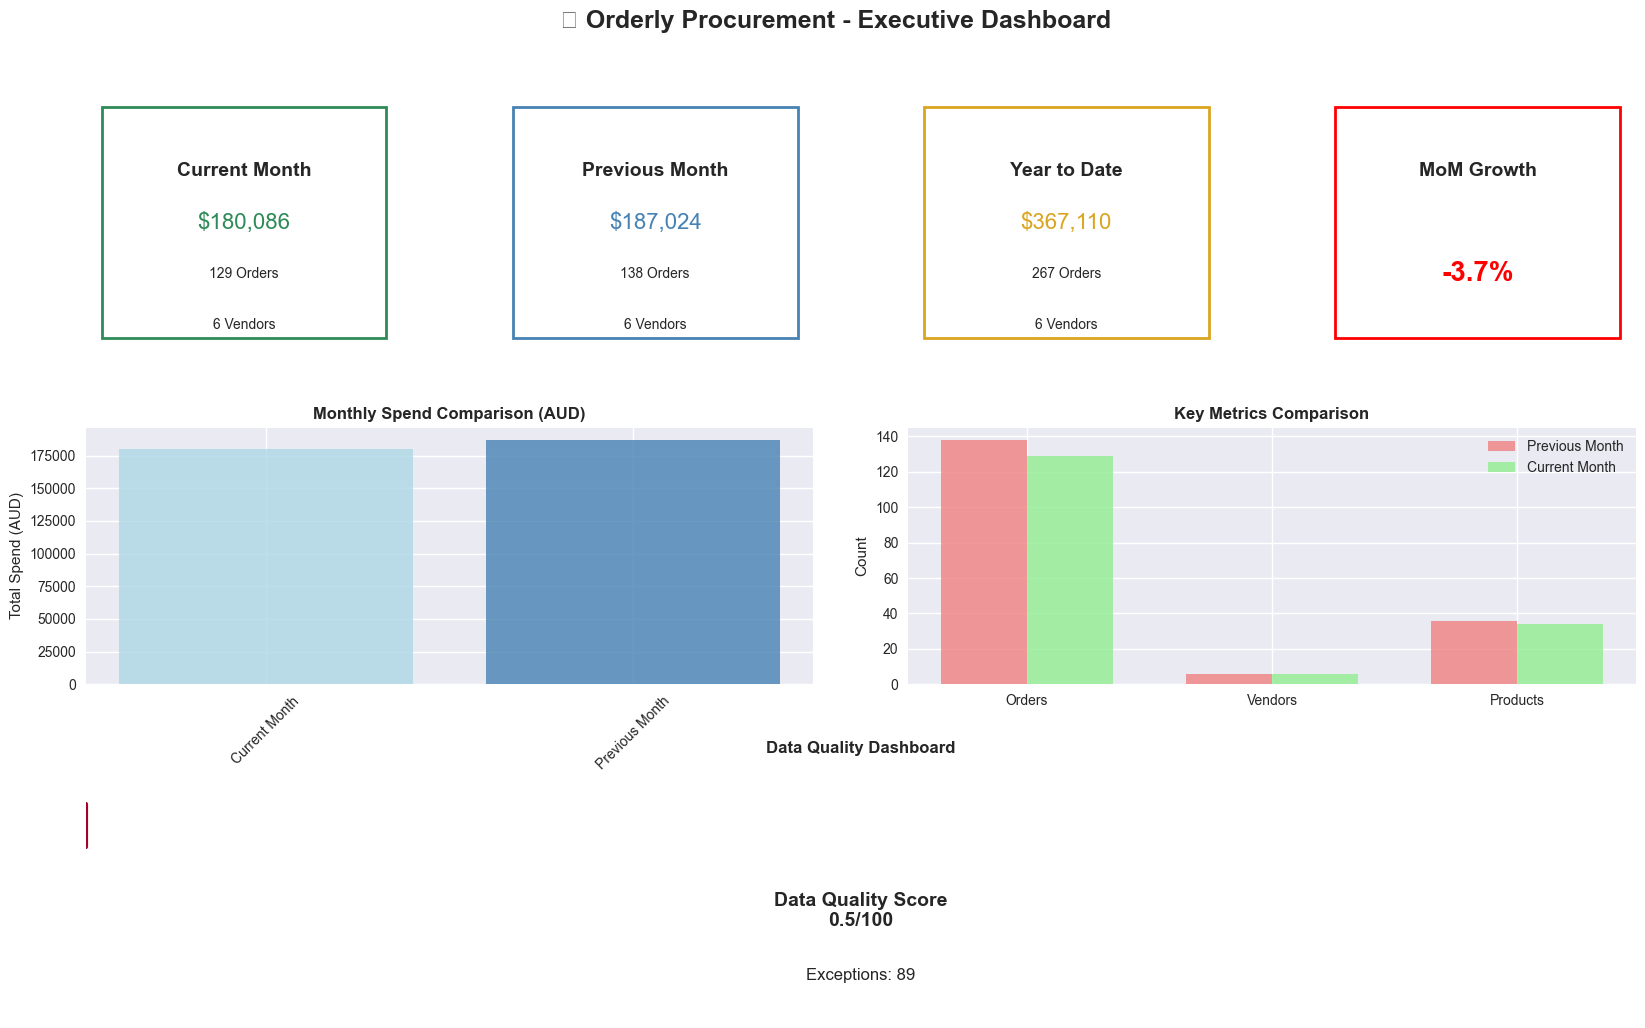


📋 EXECUTIVE SUMMARY
💰 CURRENT MONTH PERFORMANCE:
   • Total Spend: $180,085.75
   • Total Orders: 129
   • Active Vendors: 6
   • Average Line Value: $1,396.01

📊 MONTH-OVER-MONTH: Spend 📉 DECREASED by 3.7%

🗓️ YEAR-TO-DATE TOTALS:
   • YTD Spend: $367,110.08
   • YTD Orders: 267
   • YTD Vendors: 6

🎯 DATA QUALITY METRICS:
   • Quality Score: 0.5/100
   • Total Exceptions: 89



In [91]:
# Executive Dashboard Visualization
fig = plt.figure(figsize=(20, 12))

# Create a dashboard layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# KPI Cards (Top Row)
periods = ['Current Month', 'Previous Month', 'Year to Date']
colors = ['#2E8B57', '#4682B4', '#DAA520']

for i, period in enumerate(periods):
    if period in executive_df['period_name'].values:
        data = executive_df[executive_df['period_name'] == period].iloc[0]
        
        ax = fig.add_subplot(gs[0, i])
        ax.text(0.5, 0.7, f"{period}", ha='center', va='center', fontsize=14, fontweight='bold')
        ax.text(0.5, 0.5, f"${data['total_spend_aud']:,.0f}", ha='center', va='center', fontsize=16, color=colors[i])
        ax.text(0.5, 0.3, f"{data['total_orders']:,.0f} Orders", ha='center', va='center', fontsize=10)
        ax.text(0.5, 0.1, f"{data['active_vendors']:,.0f} Vendors", ha='center', va='center', fontsize=10)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        
        # Add border
        rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, linewidth=2, edgecolor=colors[i], facecolor='none')
        ax.add_patch(rect)

# Growth Indicator
if not executive_df[executive_df['period_name'] == 'Current Month']['mom_spend_growth_percent'].isna().all():
    growth = executive_df[executive_df['period_name'] == 'Current Month']['mom_spend_growth_percent'].iloc[0]
    ax_growth = fig.add_subplot(gs[0, 3])
    color = 'green' if growth >= 0 else 'red'
    ax_growth.text(0.5, 0.7, "MoM Growth", ha='center', va='center', fontsize=14, fontweight='bold')
    ax_growth.text(0.5, 0.3, f"{growth:.1f}%", ha='center', va='center', fontsize=20, color=color, fontweight='bold')
    ax_growth.set_xlim(0, 1)
    ax_growth.set_ylim(0, 1)
    ax_growth.axis('off')
    
    # Add border
    rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, linewidth=2, edgecolor=color, facecolor='none')
    ax_growth.add_patch(rect)

# Spend Trend Chart (Middle Left)
ax1 = fig.add_subplot(gs[1, :2])
spend_data = executive_df[executive_df['period_name'].isin(['Previous Month', 'Current Month'])]
ax1.bar(spend_data['period_name'], spend_data['total_spend_aud'], color=['lightblue', 'steelblue'], alpha=0.8)
ax1.set_title('Monthly Spend Comparison (AUD)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Spend (AUD)')
ax1.tick_params(axis='x', rotation=45)

# Key Metrics Comparison (Middle Right)
ax2 = fig.add_subplot(gs[1, 2:])
metrics = ['total_orders', 'active_vendors', 'unique_products']
metric_labels = ['Orders', 'Vendors', 'Products']
current_data = executive_df[executive_df['period_name'] == 'Current Month'].iloc[0]
previous_data = executive_df[executive_df['period_name'] == 'Previous Month'].iloc[0]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, [previous_data[m] for m in metrics], width, label='Previous Month', alpha=0.8, color='lightcoral')
bars2 = ax2.bar(x + width/2, [current_data[m] for m in metrics], width, label='Current Month', alpha=0.8, color='lightgreen')

ax2.set_title('Key Metrics Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count')
ax2.set_xticks(x)
ax2.set_xticklabels(metric_labels)
ax2.legend()

# Data Quality Summary (Bottom)
ax3 = fig.add_subplot(gs[2, :])
quality_data = executive_df[executive_df['period_name'] == 'Current Month'].iloc[0]
quality_score = quality_data['avg_data_quality_score']
total_exceptions = quality_data['total_exceptions']

# Create a gauge-like visualization for data quality
theta = np.linspace(0, np.pi, 100)
quality_normalized = quality_score / 100  # Assuming quality score is 0-100
colors_grad = plt.cm.RdYlGn(np.linspace(0, 1, 100))

for i, (t, c) in enumerate(zip(theta, colors_grad)):
    if i/100 <= quality_normalized:
        ax3.plot([t, t], [0.8, 1], color=c, linewidth=3)

ax3.text(np.pi/2, 0.5, f"Data Quality Score\n{quality_score:.1f}/100", ha='center', va='center', fontsize=14, fontweight='bold')
ax3.text(np.pi/2, 0.2, f"Exceptions: {total_exceptions:.0f}", ha='center', va='center', fontsize=12)
ax3.set_xlim(0, np.pi)
ax3.set_ylim(0, 1.2)
ax3.axis('off')
ax3.set_title('Data Quality Dashboard', fontsize=12, fontweight='bold')

plt.suptitle('📈 Orderly Procurement - Executive Dashboard', fontsize=18, fontweight='bold', y=0.95)
plt.show()

# Executive Summary Text
print("\n" + "="*80)
print("📋 EXECUTIVE SUMMARY")
print("="*80)

current = executive_df[executive_df['period_name'] == 'Current Month'].iloc[0]
previous = executive_df[executive_df['period_name'] == 'Previous Month'].iloc[0]
ytd = executive_df[executive_df['period_name'] == 'Year to Date'].iloc[0]

print(f"💰 CURRENT MONTH PERFORMANCE:")
print(f"   • Total Spend: ${current['total_spend_aud']:,.2f}")
print(f"   • Total Orders: {current['total_orders']:,.0f}")
print(f"   • Active Vendors: {current['active_vendors']:,.0f}")
print(f"   • Average Line Value: ${current['avg_line_value']:,.2f}")

if not pd.isna(current['mom_spend_growth_percent']):
    growth_direction = "📈 INCREASED" if current['mom_spend_growth_percent'] >= 0 else "📉 DECREASED"
    print(f"\n📊 MONTH-OVER-MONTH: Spend {growth_direction} by {abs(current['mom_spend_growth_percent']):.1f}%")

print(f"\n🗓️ YEAR-TO-DATE TOTALS:")
print(f"   • YTD Spend: ${ytd['total_spend_aud']:,.2f}")
print(f"   • YTD Orders: {ytd['total_orders']:,.0f}")
print(f"   • YTD Vendors: {ytd['active_vendors']:,.0f}")

print(f"\n🎯 DATA QUALITY METRICS:")
print(f"   • Quality Score: {current['avg_data_quality_score']:.1f}/100")
print(f"   • Total Exceptions: {current['total_exceptions']:,.0f}")

print("\n" + "="*80)

## 🔧 Cleanup and Connection Management

Close database connection and cleanup resources.

In [92]:
# Close database connection
conn.close()
print("✅ Database connection closed successfully")
print(f"📊 Analysis completed at: {datetime.now()}")
print("\n🎉 Orderly Business Analytics Report Complete!")

✅ Database connection closed successfully
📊 Analysis completed at: 2025-08-11 14:59:22.457216

🎉 Orderly Business Analytics Report Complete!
